In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Simulation Parameters
N_SIMULATIONS = 1000000  # Number of packages simulated
BASE_DELIVERY_TIME = 3  # Days under normal conditions

# Weather and Strike Parameters
# Whether delays will be randomly assigned as we don't have a specific data
# Rest of the parameter based on the real data
WIND_PROB = 0.01
WIND_DELAY = np.random.randint(0.5, 1, N_SIMULATIONS)  

RAIN_PROB = 0.05  
RAIN_DELAY = np.random.randint(1, 2, N_SIMULATIONS)  

SNOW_PROB = 0.17 
SNOW_DELAY = np.random.randint(1, 2, N_SIMULATIONS)  

HIGH_SNOW_PROB = 0.05 
HIGH_SNOW_DELAY = np.random.randint(2, 3, N_SIMULATIONS)  

STORM_DELAY = 4

ICE_PROB = 0.31  
ICE_AFTER_SNOW_PROB = 0.4
ICE_DELAY = np.random.randint(1, 2, N_SIMULATIONS)  

# Short Strike of lenght of 0 to 3 days
SHORT_STRIKE_PROB = 0.0052
SHORT_STRIKE_DELAY = 1.61

# Long Strike of lenght of more than 3 days
LONG_STRIKE_PROB = 0.0014
LONG_STRIKE_DELAY = 8.6

#LOGISTICS_PROB = 0.2  # 20% chance of logistics overload
#LOGISTICS_DELAY = np.random.randint(1, 2, N_SIMULATIONS)  # 1-2 extra days


In [3]:
# Monte Carlo Simulation
def simulate_delivery():
    delays = np.zeros(N_SIMULATIONS)  # Initialize delays array

    # --- Heavy snow and normal snow (mutually exclusive) ---
    high_snow_occurs = np.random.rand(N_SIMULATIONS) < HIGH_SNOW_PROB
    delays += high_snow_occurs * HIGH_SNOW_DELAY

    # Normal snow occurs only if heavy snow did not occur
    snow_occurs = (np.random.rand(N_SIMULATIONS) < SNOW_PROB) & (~high_snow_occurs)
    delays += snow_occurs * SNOW_DELAY

    # --- Rain and snow (mutually exclusive approximation) ---
    # Only rain if snow (normal or heavy) did not happen
    rain_occurs = (np.random.rand(N_SIMULATIONS) < RAIN_PROB) & (~snow_occurs) & (~high_snow_occurs)
    delays += rain_occurs * RAIN_DELAY

    # --- Wind (independent) ---
    wind_occurs = np.random.rand(N_SIMULATIONS) < WIND_PROB
    delays += wind_occurs * WIND_DELAY

    # --- Storm event (combined wind + rain or snow) replaces individual delays if occurred ---
    storm_occurs = wind_occurs & (rain_occurs | snow_occurs | high_snow_occurs)
    delays[storm_occurs] -= (wind_occurs * WIND_DELAY + rain_occurs * RAIN_DELAY + snow_occurs * SNOW_DELAY + high_snow_occurs * HIGH_SNOW_DELAY)[storm_occurs]
    delays[storm_occurs] += STORM_DELAY

    # --- Ice: can occur independently, but more likely after heavy snow ---
    base_ice_occurs = np.random.rand(N_SIMULATIONS) < ICE_PROB
    conditional_ice_after_snow = high_snow_occurs & (np.random.rand(N_SIMULATIONS) < ICE_AFTER_SNOW_PROB)
    ice_occurs = base_ice_occurs | conditional_ice_after_snow
    delays += ice_occurs * ICE_DELAY

    # --- Strikes: only one type of strike can happen at a time ---
    strike_randoms = np.random.rand(N_SIMULATIONS)
    long_strike_occurs = strike_randoms < LONG_STRIKE_PROB
    short_strike_occurs = (strike_randoms < SHORT_STRIKE_PROB) & (~long_strike_occurs)

    delays += long_strike_occurs * LONG_STRIKE_DELAY
    delays += short_strike_occurs * SHORT_STRIKE_DELAY

    # Logistics delay
    #logistics_occurs = np.random.rand(N_SIMULATIONS) < LOGISTICS_PROB
    # delays += logistics_occurs * LOGISTICS_DELAY

    # --- Total delivery time ---
    total_delivery_time = BASE_DELIVERY_TIME + delays
    return total_delivery_time

In [4]:
# Run Simulation
delivery_times = simulate_delivery()

In [5]:
# Statistical Analysis
mean_delivery = np.mean(delivery_times)
median_delivery = np.median(delivery_times)
prob_over_5_days = np.mean(delivery_times > 5)
prob_over_10_days = np.mean(delivery_times > 10)

In [6]:
# Display Results
print(f"Mean Delivery Time: {mean_delivery:.2f} days")
print(f"Median Delivery Time: {median_delivery:.2f} days")
print(f"Probability of Delivery > 5 days: {prob_over_5_days:.2%}")
print(f"Probability of Delivery > 10 days: {prob_over_10_days:.2%}")

Mean Delivery Time: 3.71 days
Median Delivery Time: 3.00 days
Probability of Delivery > 5 days: 3.83%
Probability of Delivery > 10 days: 0.66%


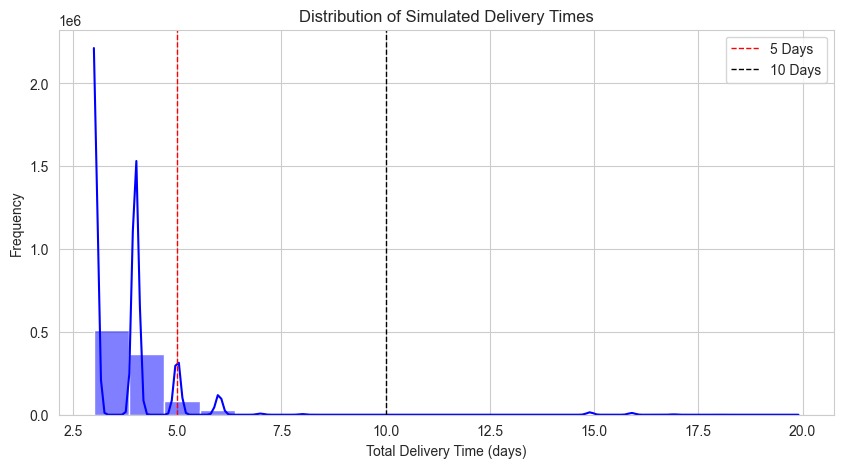

In [7]:
# Visualization
plt.figure(figsize=(10,5))
sns.histplot(delivery_times, bins=20, kde=True, color='blue')
plt.axvline(5, color='red', linestyle='dashed', linewidth=1, label='5 Days')
plt.axvline(10, color='black', linestyle='dashed', linewidth=1, label='10 Days')
plt.xlabel('Total Delivery Time (days)')
plt.ylabel('Frequency')
plt.title('Distribution of Simulated Delivery Times')
plt.legend()
plt.show()